# Training Dataset Creation

---

The `training dataset` abstraction in Hopsworks Feature Store allows users to group a set of features (potentially from multiple different feature groups) with labels for training a model to do a particular prediction task. The `training dataset` is a versioned and managed dataset and is stored in HopsFS as **tfrecords**, **parquet**, **csv**, or **tsv** files.

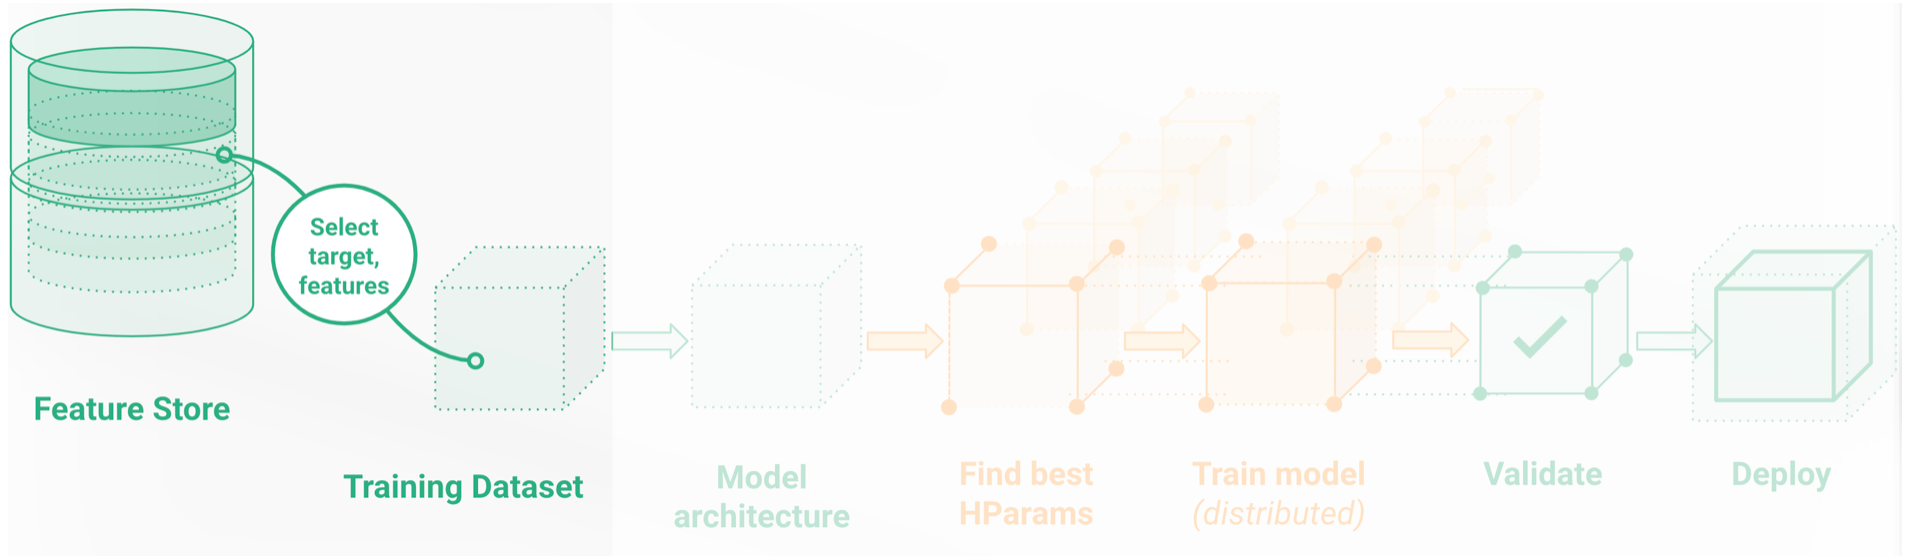

In this notebook, we will create the actual dataset that we will train our model on. In particular, we will:
1. Select the features we want to train our model on.
2. Specify how the features should be preprocessed.
3. Create a dataset split for training and validation data.

---

# 🔮 Connecting to Feature Store 

In [1]:
import hsfs

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


---

# 🔮 Retrieving Feature Groups

> In order to retrieve necessary Feature Group we can use `FeatureStore.get_feature_group()` method.

In [2]:
fg_weather = fs.get_feature_group(
    name = 'weather_fg',
    version = 1
)

In [3]:
fg_calendar = fs.get_feature_group(
    name = 'calendar_fg',
    version = 1
)

In [4]:
fg_electricity = fs.get_feature_group(
    name = 'electricity_fg',
    version = 1
)

---

# 🕵🏻‍♂️ Feature Groups Investigation

We can use `FeatureGroup.show()` method to select top n rows. 

Also we use method `FeatureGroup.read()` in order **to aggregate queries**, which are the output of next methods:

- `FeatureGroup.get_feture()` to get specific feature from our Feature Group.

- `FeatureGroup.select()` to get a few features from our Feature Group.

- `FeatureGroup.select_all()` to get all features from our Feature Group.

- `FeatureGroup.select_except()` to get all features except a few from our Feature Group.

- `FeatureGroup.filter()` in order to apply specific filter to the feature group.

In [5]:
fg_weather.select_all()

In [6]:
fg_weather.select_all().read().head()

2022-05-19 17:19:18,636 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:19,381 INFO: SELECT `fg0`.`index` `index`, `fg0`.`date` `date`, `fg0`.`min_temperature` `min_temperature`, `fg0`.`max_temperature` `max_temperature`, `fg0`.`solar_exposure` `solar_exposure`, `fg0`.`rainfall` `rainfall`, `fg0`.`day_of_week` `day_of_week`, `fg0`.`day_of_month` `day_of_month`, `fg0`.`day_of_year` `day_of_year`, `fg0`.`week_of_year` `week_of_year`, `fg0`.`month` `month`, `fg0`.`quarter` `quarter`, `fg0`.`year` `year`
FROM `electricity_demand_featurestore`.`weather_fg_1` `fg0`


,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,month,quarter,year
0,866,2017-05-16,5.6,18.2,9.0,0.0,1,16,136,20,5,2,2017
1,848,2017-04-28,9.4,19.8,6.0,0.4,4,28,118,17,4,2,2017
2,762,2017-02-01,14.3,20.6,9.3,0.0,2,1,32,5,2,1,2017
3,1506,2019-02-15,14.8,22.8,23.1,0.0,4,15,46,7,2,1,2019
4,348,2015-12-15,14.4,24.6,30.3,0.0,1,15,349,51,12,4,2015


In [7]:
fg_calendar.select_except(['index']).show(5)

2022-05-19 17:19:20,829 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:21,582 INFO: SELECT `fg0`.`date` `date`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`
FROM `electricity_demand_featurestore`.`calendar_fg_1` `fg0`


,date,school_day,holiday
0,2017-05-16,1,0
1,2017-04-28,1,0
2,2017-02-01,1,0
3,2019-02-15,1,0
4,2015-12-15,1,0


In [8]:
fg_electricity.select('demand').show(5)

2022-05-19 17:19:23,153 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:23,893 INFO: SELECT `fg0`.`demand` `demand`
FROM `electricity_demand_featurestore`.`electricity_fg_1` `fg0`


,demand
0,127820.715
1,120144.190
2,114133.730
3,113910.460
4,129077.410


In [9]:
fg_electricity.filter(fg_electricity.demand > 10000).show(5)

2022-05-19 17:19:25,253 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:25,982 INFO: SELECT `fg0`.`index` `index`, `fg0`.`date` `date`, `fg0`.`rrp` `rrp`, `fg0`.`frac_at_neg_rrp` `frac_at_neg_rrp`, `fg0`.`demand` `demand`, `fg0`.`rrp_positive` `rrp_positive`, `fg0`.`demand_neg_rrp` `demand_neg_rrp`, `fg0`.`rrp_negative` `rrp_negative`, `fg0`.`demand_pos_rrp` `demand_pos_rrp`, `fg0`.`demand_7_mean` `demand_7_mean`, `fg0`.`demand_7_std` `demand_7_std`, `fg0`.`demand_14_mean` `demand_14_mean`, `fg0`.`demand_14_std` `demand_14_std`, `fg0`.`demand_30_mean` `demand_30_mean`, `fg0`.`demand_30_std` `demand_30_std`
FROM `electricity_demand_featurestore`.`electricity_fg_1` `fg0`
WHERE `fg0`.`demand` > 10000


,index,date,rrp,frac_at_neg_rrp,demand,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,866,2017-05-16,128.314908,0.0,127820.715,128.314908,0.0,0.0,127820.715,121241.563571,8887.883403,120953.853214,9123.157142,115519.939500,10017.568625
1,848,2017-04-28,120.809522,0.0,120144.190,120.809522,0.0,0.0,120144.190,110589.211429,10806.963325,108857.468214,9304.957057,108043.033667,8338.657732
2,762,2017-02-01,66.863303,0.0,114133.730,66.863303,0.0,0.0,114133.730,111392.955000,7705.228365,112075.955357,10942.769521,114520.121833,13282.913559
3,1506,2019-02-15,114.768504,0.0,113910.460,114.768504,0.0,0.0,113910.460,105785.246429,7812.404552,116915.945357,14520.367253,122180.743500,18733.589095
4,348,2015-12-15,51.660830,0.0,129077.410,51.660830,0.0,0.0,129077.410,119227.231429,10026.436291,121011.467143,9403.845094,119349.545500,10540.984736


---

# 🧑🏻‍🔬 Transformation functions

Hopsworks Feature Store provides functionality to attach transformation functions to training datasets.

Hopsworks Feature Store also comes with built-in transformation functions such as `min_max_scaler`, `standard_scaler`, `robust_scaler` and `label_encoder`.

In [10]:
[t_func.name for t_func in fs.get_transformation_functions()]

['robust_scaler', 'min_max_scaler', 'standard_scaler', 'label_encoder']

We can retrieve transformation function we need .

To attach transformation function to training dataset provide transformation functions as dict, where key is feature name and value is online transformation function name.

Also training dataset must be created from the Query object. Once attached transformation function will be applied on whenever save, insert and get_serving_vector methods are called on training dataset object.

In [11]:
# Load transformation functions.
standard_scaler = fs.get_transformation_function(name = 'standard_scaler')
label_encoder = fs.get_transformation_function(name = 'label_encoder')

#Map features to transformations.
mapping_transformers = {
    "rrp_positive": standard_scaler,
    "rrp_negative": standard_scaler,
    "school_day": label_encoder,
    "holiday": label_encoder
}

---

## 💼 Query Preparation

In [12]:
fg_query = fg_weather.select_all()\
                        .join(
                            fg_calendar.select_all(),
                            on = ['index','date']
                        )\
                        .join(
                            fg_electricity.select_all(),
                            on = ['index','date']
                        )
fg_query.show(5)

2022-05-19 17:19:29,573 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:30,322 INFO: SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, `fg1`.`rrp` `rrp`, `fg1`.`frac_at_neg_rrp` `frac_at_neg_rrp`, `fg1`.`demand` `demand`, `fg1`.`rrp_positive` `rrp_positive`, `fg1`.`demand_neg_rrp` `demand_neg_rrp`, `fg1`.`rrp_negative` `rrp_negative`, `fg1`.`demand_pos_rrp` `demand_pos_rrp`, `fg1`.`demand_7_mean` `demand_7_mean`, `fg1`.`demand_7_std` `demand_7_std`, `fg1`.`demand_14_mean` `demand_14_mean`, `fg1`.`demand_14_std` `demand_14_std`, `fg1`.`demand_30_mean

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,1803,2019-12-09,16.3,38.0,28.6,0.0,0,9,343,50,...,70.771049,11257.86,-20.717997,116652.975,107191.424286,10557.275237,107408.967857,8256.705104,107776.225500,8689.339445
1,465,2016-04-10,13.6,23.5,9.6,0.0,6,10,101,14,...,35.120546,0.00,0.000000,99845.345,117899.222143,9814.535425,115225.037857,9747.522729,115691.728167,11512.879110
2,550,2016-07-04,10.4,12.7,3.6,0.0,0,4,186,27,...,124.136886,0.00,0.000000,135712.245,131846.523571,11495.037409,134462.529643,9735.529029,132402.165167,9085.695593
3,168,2015-06-18,10.7,12.7,4.2,1.0,3,18,169,25,...,37.457764,0.00,0.000000,137073.775,133482.565000,8990.376248,131278.706429,12342.700424,131822.913833,11642.171736
4,1899,2020-03-14,13.1,17.9,12.3,0.6,5,14,74,11,...,29.137326,0.00,0.000000,96016.190,107076.063571,12177.997814,107961.805714,10022.328767,110341.526500,10557.434759


---

# 🔬 🧬 Feature Views

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

In order to create Feature View we can use `FeatureStore.create_feature_view()` method.

In [13]:
feature_view = fs.create_feature_view(
    name = 'electricity_data',
    version = 1,
    query = fg_query
)

In [14]:
feature_view

For now `Feature View` is saved in Hopsworks and we can retrieve it using `FeatureStore.get_feature_view()`.

In [15]:
feature_view = fs.get_feature_view(
    name = 'electricity_data',
    version = 1
)

In [16]:
feature_view.version

1

> `FeatureView.preview_feature_vector()` returns a sample of assembled serving vector from online feature store.

> To get subset of data use `FeatureView.get_batch_data()` which returns DataFrame.

In [17]:
feature_view.preview_feature_vector()

[7,
 '2015-01-08',
 23.1,
 28.2,
 13.5,
 19.4,
 3,
 8,
 8,
 2,
 1,
 1,
 2015,
 0,
 0,
 20.24010323118855,
 0.0,
 119692.025,
 20.24010323118855,
 0.0,
 0.0,
 119692.025,
 131618.8757142857,
 13445.31335961138,
 126909.86321428572,
 13588.001359338332,
 122458.71350000001,
 15761.914692977727]

In [18]:
df_batch = feature_view.get_batch_data()
type(df_batch)

2022-05-19 17:19:55,781 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:19:56,512 INFO: SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, `fg1`.`rrp` `rrp`, `fg1`.`frac_at_neg_rrp` `frac_at_neg_rrp`, `fg1`.`demand` `demand`, `fg1`.`rrp_positive` `rrp_positive`, `fg1`.`demand_neg_rrp` `demand_neg_rrp`, `fg1`.`rrp_negative` `rrp_negative`, `fg1`.`demand_pos_rrp` `demand_pos_rrp`, `fg1`.`demand_7_mean` `demand_7_mean`, `fg1`.`demand_7_std` `demand_7_std`, `fg1`.`demand_14_mean` `demand_14_mean`, `fg1`.`demand_14_std` `demand_14_std`, `fg1`.`demand_30_mean

pandas.core.frame.DataFrame

In [19]:
df_batch.head()

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,1803,2019-12-09,16.3,38.0,28.6,0.0,0,9,343,50,...,70.771049,11257.86,-20.717997,116652.975,107191.424286,10557.275237,107408.967857,8256.705104,107776.225500,8689.339445
1,465,2016-04-10,13.6,23.5,9.6,0.0,6,10,101,14,...,35.120546,0.00,0.000000,99845.345,117899.222143,9814.535425,115225.037857,9747.522729,115691.728167,11512.879110
2,550,2016-07-04,10.4,12.7,3.6,0.0,0,4,186,27,...,124.136886,0.00,0.000000,135712.245,131846.523571,11495.037409,134462.529643,9735.529029,132402.165167,9085.695593
3,168,2015-06-18,10.7,12.7,4.2,1.0,3,18,169,25,...,37.457764,0.00,0.000000,137073.775,133482.565000,8990.376248,131278.706429,12342.700424,131822.913833,11642.171736
4,1899,2020-03-14,13.1,17.9,12.3,0.6,5,14,74,11,...,29.137326,0.00,0.000000,96016.190,107076.063571,12177.997814,107961.805714,10022.328767,110341.526500,10557.434759


---

## 🧬 Dataset Creation 

To create training dataset we use `FeatureView.create_training_dataset()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- We can choose necessary format using **data_format** parameter.

- Also we can specify split ratio using **splits** parameter.

- **train_split** - specify which split will be used for training.

In [20]:
feature_view.create_training_dataset(
    version = 1,
    description = 'trial_dataset',
    data_format = 'csv',
    splits = {'train': 80, 'validation': 20},
    train_split = "train",
    write_options = {'wait_for_job': False}
)

Training dataset job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/electricity_data_1_1_create_fv_td_19052022172019/executions


(1, <hsfs.core.job.Job at 0x7f78569fcac0>)

Now our dataset has been splitted into two parts: **train(80% of original dataset)** and **validation(20% of original dataset)**.

> To get **training dataset** we can use `FeatureView.get_training_dataset()` method.

> To retrieve specific part of **training dataset** use `FeatureView.get_training_dataset_splits()` method.

In [21]:
td_version, df = feature_view.get_training_dataset()

df.head()

2022-05-19 17:20:21,518 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:20:22,343 INFO: SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, `fg1`.`rrp` `rrp`, `fg1`.`frac_at_neg_rrp` `frac_at_neg_rrp`, `fg1`.`demand` `demand`, `fg1`.`rrp_positive` `rrp_positive`, `fg1`.`demand_neg_rrp` `demand_neg_rrp`, `fg1`.`rrp_negative` `rrp_negative`, `fg1`.`demand_pos_rrp` `demand_pos_rrp`, `fg1`.`demand_7_mean` `demand_7_mean`, `fg1`.`demand_7_std` `demand_7_std`, `fg1`.`demand_14_mean` `demand_14_mean`, `fg1`.`demand_14_std` `demand_14_std`, `fg1`.`demand_30_mean

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,1803,2019-12-09,16.3,38.0,28.6,0.0,0,9,343,50,...,70.771049,11257.86,-20.717997,116652.975,107191.424286,10557.275237,107408.967857,8256.705104,107776.225500,8689.339445
1,465,2016-04-10,13.6,23.5,9.6,0.0,6,10,101,14,...,35.120546,0.00,0.000000,99845.345,117899.222143,9814.535425,115225.037857,9747.522729,115691.728167,11512.879110
2,550,2016-07-04,10.4,12.7,3.6,0.0,0,4,186,27,...,124.136886,0.00,0.000000,135712.245,131846.523571,11495.037409,134462.529643,9735.529029,132402.165167,9085.695593
3,168,2015-06-18,10.7,12.7,4.2,1.0,3,18,169,25,...,37.457764,0.00,0.000000,137073.775,133482.565000,8990.376248,131278.706429,12342.700424,131822.913833,11642.171736
4,1899,2020-03-14,13.1,17.9,12.3,0.6,5,14,74,11,...,29.137326,0.00,0.000000,96016.190,107076.063571,12177.997814,107961.805714,10022.328767,110341.526500,10557.434759


In [22]:
td_version, df = feature_view.get_training_dataset_splits(
    splits = {}
)

df.head()

2022-05-19 17:20:47,222 INFO: USE `electricity_demand_featurestore`
2022-05-19 17:20:48,010 INFO: SELECT `fg2`.`index` `index`, `fg2`.`date` `date`, `fg2`.`min_temperature` `min_temperature`, `fg2`.`max_temperature` `max_temperature`, `fg2`.`solar_exposure` `solar_exposure`, `fg2`.`rainfall` `rainfall`, `fg2`.`day_of_week` `day_of_week`, `fg2`.`day_of_month` `day_of_month`, `fg2`.`day_of_year` `day_of_year`, `fg2`.`week_of_year` `week_of_year`, `fg2`.`month` `month`, `fg2`.`quarter` `quarter`, `fg2`.`year` `year`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`, `fg1`.`rrp` `rrp`, `fg1`.`frac_at_neg_rrp` `frac_at_neg_rrp`, `fg1`.`demand` `demand`, `fg1`.`rrp_positive` `rrp_positive`, `fg1`.`demand_neg_rrp` `demand_neg_rrp`, `fg1`.`rrp_negative` `rrp_negative`, `fg1`.`demand_pos_rrp` `demand_pos_rrp`, `fg1`.`demand_7_mean` `demand_7_mean`, `fg1`.`demand_7_std` `demand_7_std`, `fg1`.`demand_14_mean` `demand_14_mean`, `fg1`.`demand_14_std` `demand_14_std`, `fg1`.`demand_30_mean

,index,date,min_temperature,max_temperature,solar_exposure,rainfall,day_of_week,day_of_month,day_of_year,week_of_year,...,rrp_positive,demand_neg_rrp,rrp_negative,demand_pos_rrp,demand_7_mean,demand_7_std,demand_14_mean,demand_14_std,demand_30_mean,demand_30_std
0,1803,2019-12-09,16.3,38.0,28.6,0.0,0,9,343,50,...,70.771049,11257.86,-20.717997,116652.975,107191.424286,10557.275237,107408.967857,8256.705104,107776.225500,8689.339445
1,465,2016-04-10,13.6,23.5,9.6,0.0,6,10,101,14,...,35.120546,0.00,0.000000,99845.345,117899.222143,9814.535425,115225.037857,9747.522729,115691.728167,11512.879110
2,550,2016-07-04,10.4,12.7,3.6,0.0,0,4,186,27,...,124.136886,0.00,0.000000,135712.245,131846.523571,11495.037409,134462.529643,9735.529029,132402.165167,9085.695593
3,168,2015-06-18,10.7,12.7,4.2,1.0,3,18,169,25,...,37.457764,0.00,0.000000,137073.775,133482.565000,8990.376248,131278.706429,12342.700424,131822.913833,11642.171736
4,1899,2020-03-14,13.1,17.9,12.3,0.6,5,14,74,11,...,29.137326,0.00,0.000000,96016.190,107076.063571,12177.997814,107961.805714,10022.328767,110341.526500,10557.434759


---

### Next Steps

In the next notebook, we will train a model on the dataset we created in this notebook.